# Cryptopals Challenge Set 4

https://cryptopals.com/sets/4

## 25. Break "random access read/write" AES CTR

https://cryptopals.com/sets/4/challenges/25

In [1]:
import os
from base64 import b64decode
from cryptopals.utils import aes_ecb_decrypt, aes_ctr_decode_encode

with open("input/25.txt") as f:
    cipher_ = b64decode(f.read())
    plaintext25 = aes_ecb_decrypt(cipher_,b"YELLOW SUBMARINE")

KEY25 = os.urandom(16)
NONCE = 0
cipher25 = aes_ctr_decode_encode(plaintext25,KEY25,NONCE)

### Discussion 

Since XOR is commutative, if I gain access to a AES CTR encrypted cipher for which I know the plaintext, I can easily recover the corresponding keystream without knowing the key or the nonce. Here's the generic proof of pricinple:

In [2]:
from cryptopals import bytes_xor

plain_attack = len(cipher25)*b"A"
cipher_attack = aes_ctr_decode_encode(plain_attack,KEY25,NONCE)
keystream_recover = bytes_xor(plain_attack,cipher_attack)
plain_recover = bytes_xor(cipher25,keystream_recover)
print(plain_recover[:200].decode(), "...")

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy ...


### Attack

Assuming I have access to a "random access" read/write API like that described by the challenge and I can read the oringial ciphertext, I would then implement something like the following. The efficiency of the attack depends on the size of the injected chunk, the larger the chunk the fewer call to the re-encrypting API.

In [3]:
from cryptopals.utils import generate_ctr_keystream, bytes_xor

def edit(ciphertext, offset, newtext, key=KEY25, nonce=NONCE):
    keystream = generate_ctr_keystream(key, nonce, offset+len(newtext))   
    newcipher = bytes_xor(newtext,keystream[offset:])
    result = ciphertext[:offset] + newcipher + ciphertext[offset+len(newtext):]
    return result

def break_random_access_read_write_AES_CTR(cipher,chuncksize=1000):
    keystream_recover = b""
    for i in range(len(cipher)//chuncksize+1):
        cipher_edit = edit(cipher, i*chuncksize, chuncksize*b"A")
        keystream_recover += bytes_xor(chuncksize*b"A",cipher_edit[i*chuncksize:(i+1)*chuncksize])
    return bytes_xor(cipher,keystream_recover)

plain25 = break_random_access_read_write_AES_CTR(cipher25)
print(plain25.decode()[:200], "...")

I'm back and I'm ringin' the bell 
A rockin' on the mike while the fly girls yell 
In ecstasy in the back of me 
Well that's my DJ Deshay cuttin' all them Z's 
Hittin' hard and the girlies goin' crazy ...


## 26. CTR bitflipping

https://cryptopals.com/sets/4/challenges/26

### Attack

Same strategy than Challenge 16, it just works!

In [4]:
from Cryptodome.Cipher import AES
from cryptopals.utils import aes_ctr_decode_encode
import os

BLOCKSIZE = AES.block_size
KEYSIZE = 32

class profile_functions_26:
    def __init__(self,key=None, nonce=0):
        if not key:
            self.key = os.urandom(KEYSIZE)
        else:
            self.key = key
        self.nonce = nonce
            
    def wrap_userdata(self, data: bytes) -> bytes:
        prefix = b"comment1=cooking%20MCs;userdata="
        suffix = b";comment2=%20like%20a%20pound%20of%20bacon"
        data = data.replace(b";",b"%3B").replace(b"=",b"%3D") # The function should quote out the ";" and "=" characters.
        wrapped = prefix + data + suffix
        return aes_ctr_decode_encode(wrapped,self.key,self.nonce)
    
    def check_for_admin(self, data: bytes, quiet=False) -> bool:
        plaintext = aes_ctr_decode_encode(data,self.key,self.nonce)
        if not quiet:
            print(f"{plaintext=}")
        return b";admin=true;" in plaintext

def make_bitflipping_attack(profile, inject=b";admin=true;") -> bytes:
    a_block = b"A" * BLOCKSIZE
    cipher = profile.wrap_userdata(2*a_block)
    # right justify injection block with padding
    injection = inject.rjust(BLOCKSIZE, b"A")
    flipper = bytes_xor(a_block,injection)
    # flipped block will be 4th block in plain text, it's then left justified to the lenght of the ciphertext
    padded = flipper.rjust(3*BLOCKSIZE, b"\x00").ljust(len(cipher), b"\x00")
    # xor with original encrypter wrapped user data
    cipher_new = bytes_xor(cipher,padded)
    return cipher_new

profile26 = profile_functions_26()

cipher_test = profile26.wrap_userdata(b";admin=true;")
test = profile26.check_for_admin(cipher_test,False)
if not test:
    print("TEST: ';admin=true;' correctly escaped\n")

attack_data = make_bitflipping_attack(profile26,inject=b";admin=true;")
if profile26.check_for_admin(attack_data,False):
    print("ATTACK: injection successfull!")

plaintext=b'comment1=cooking%20MCs;userdata=%3Badmin%3Dtrue%3B;comment2=%20like%20a%20pound%20of%20bacon'
TEST: ';admin=true;' correctly escaped

plaintext=b'comment1=cooking%20MCs;userdata=AAAA;admin=true;AAAAAAAAAAAAAAAA;comment2=%20like%20a%20pound%20of%20bacon'
ATTACK: injection successfull!


## 27. Recover the key from CBC with IV=Key

https://cryptopals.com/sets/4/challenges/27

In [5]:
from Cryptodome.Cipher import AES
from cryptopals import pkcs7_pad, pkcs7_strip
import os

class oracle_27:
    def __init__(self):
        self.key = os.urandom(AES.block_size)
        self.iv = self.key # repurposes the key for CBC encryption as the IV

    def encrypt(self, data: bytes) -> bytes:
        aes_cbc = AES.new(self.key,AES.MODE_CBC,self.iv)
        return aes_cbc.encrypt(pkcs7_pad(data))

    def decrypt(self, data: bytes) -> bytes:
        aes_cbc = AES.new(self.key,AES.MODE_CBC,self.iv)
        plaintext = pkcs7_strip(aes_cbc.decrypt(data))
        non_ascii_chars = [byte for byte in plaintext if byte > 127]
        if non_ascii_chars:
            print(f"Non-ASCII character(s) found in plaintext {plaintext}.")
            return plaintext
        else:
            print(f"Decrypting successful (but I'm not returning the plaintext).")
            return None

In [6]:
from cryptopals.utils import bytes_xor

oracle = oracle_27()
oracle.decrypt(oracle.encrypt(b"This is a test"))

# forgin P3 with high-ASCII values to trigger plaintext leak
P1_P2_P3 = 2*AES.block_size*b"A" + AES.block_size*b"\x80" 
C1_C2_C3 = oracle.encrypt(P1_P2_P3) # longer than 16*3 becouse of padding
C1 = C1_C2_C3[:AES.block_size]

# this gives padding errors!
#C1_C0_C1 = C1 + AES.block_size*b"\x00" + C1
#plain = oracle.decrypt(C1_C0_C1) 

# using the padded end of the cipher avoids padding errors, 
# while the initial part contains the attack needed to recover the key
C1_C0_C1_C2_C3 = C1 + AES.block_size*b"\x00" + C1 + C1_C2_C3 
plain_leak = oracle.decrypt(C1_C0_C1_C2_C3)

P1 = plain_leak[:AES.block_size]
P3 = plain_leak[2*AES.block_size:3*AES.block_size]
key_guess = bytes_xor(P1,P3)

print()
print(f"Key guess:  {key_guess}")
print(f"Oracle key: {oracle.key}")

Decrypting successful (but I'm not returning the plaintext).
Non-ASCII character(s) found in plaintext b'AAAAAAAAAAAAAAAA\xad\x90\xfc\x80<gy\xabk\x13\xea"\xcd\xd9\xdc\xad;\x15\x85\xbbi%\x87\xd9\xe43\xe1b\xea\x94\xb8\x9b\xee\xca\xc8K*\xac\x8d\x10\xed7Dv\xe74q7AAAAAAAAAAAAAAAA\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80'.

Key guess:  b'zT\xc4\xfa(d\xc6\x98\xa5r\xa0#\xab\xd5\xf9\xda'
Oracle key: b'zT\xc4\xfa(d\xc6\x98\xa5r\xa0#\xab\xd5\xf9\xda'


## 28. Implement a SHA-1 keyed MAC

https://cryptopals.com/sets/4/challenges/28

In [7]:
def left_rotate(value, shift):
    """Perform a left circular rotation (circular shift) on a 32-bit value."""
    return ((value << shift) | (value >> (32 - shift))) & 0xFFFFFFFF

def sha1(message,
         H0 = 0x67452301, # Initialize hash values
         H1 = 0xEFCDAB89, 
         H2 = 0x98BADCFE, 
         H3 = 0x10325476, 
         H4 = 0xC3D2E1F0,
         message_length=0 # Provide forged message lenght
        ):

    # 1. Ensure the data is a bytearray
    if isinstance(message, str):
        message = bytearray(message, 'utf-8')
    elif isinstance(message, bytes):
        message = bytearray(message)
    
    # 2. Preprocess the message (padding)
    if message_length:
        original_length = message_length * 8
    else:
        original_length = len(message) * 8  # Length in bits
    message.append(0x80)  # Append the bit '1'
    while (len(message) * 8) % 512 != 448:
        message.append(0)  # Pad with zeros
    message += original_length.to_bytes(8, 'big')  # Append original length as 64-bit big-endian
    
    # 3. Process each 512-bit chunk
    for chunk_start in range(0, len(message), 64):
        chunk = message[chunk_start:chunk_start + 64]

        # Break chunk into 16 32-bit words
        words = [int.from_bytes(chunk[i:i + 4], 'big') for i in range(0, 64, 4)]
        # Extend to 80 words
        for i in range(16, 80):
            words.append(left_rotate(words[i - 3] ^ words[i - 8] ^ words[i - 14] ^ words[i - 16], 1))

        # Initialize variables
        a, b, c, d, e = H0, H1, H2, H3, H4

        # Main loop
        for i in range(80):
            if i < 20:
                f = (b & c) | ((~b) & d)
                k = 0x5A827999
            elif i < 40:
                f = b ^ c ^ d
                k = 0x6ED9EBA1
            elif i < 60:
                f = (b & c) | (b & d) | (c & d)
                k = 0x8F1BBCDC
            else:
                f = b ^ c ^ d
                k = 0xCA62C1D6

            temp = (left_rotate(a, 5) + f + e + k + words[i]) & 0xFFFFFFFF
            e = d
            d = c
            c = left_rotate(b, 30)
            b = a
            a = temp

        # Add chunk's hash to result
        H0 = (H0 + a) & 0xFFFFFFFF
        H1 = (H1 + b) & 0xFFFFFFFF
        H2 = (H2 + c) & 0xFFFFFFFF
        H3 = (H3 + d) & 0xFFFFFFFF
        H4 = (H4 + e) & 0xFFFFFFFF

    # Produce final hash value
    return f"{H0:08x}{H1:08x}{H2:08x}{H3:08x}{H4:08x}"

In [8]:
from hashlib import sha1 as SHA1
import os

for _ in range(10):
    test = os.urandom(100)
    print(SHA1(test).digest().hex(), sha1(test), SHA1(test).digest().hex()==sha1(test))

048c501232c50ec13286d80589aa3fd5107a2bbc 048c501232c50ec13286d80589aa3fd5107a2bbc True
0203801d30feb6609d45f185ee136eb789bc5278 0203801d30feb6609d45f185ee136eb789bc5278 True
104332842216a65be7f1f6cc5c0eacacef1fdab0 104332842216a65be7f1f6cc5c0eacacef1fdab0 True
7048979d8d0f221a60a2ef2f0369a05704351edd 7048979d8d0f221a60a2ef2f0369a05704351edd True
afdcd8f3093a20f9353756c0382c5e6566f4cf38 afdcd8f3093a20f9353756c0382c5e6566f4cf38 True
afc29edb26d3a8ef91df174e049a7fdedb18e68a afc29edb26d3a8ef91df174e049a7fdedb18e68a True
31e43662f1cc9dac6d3e3a75017d1bf99a4b341d 31e43662f1cc9dac6d3e3a75017d1bf99a4b341d True
9039f72084e3839a498a7e7b6fe511e8f501c494 9039f72084e3839a498a7e7b6fe511e8f501c494 True
c508a59e0b8c53d38e27fc5d39e2e22e2ccdcdd1 c508a59e0b8c53d38e27fc5d39e2e22e2ccdcdd1 True
cd74262bb61ec5f3d9e3378169f5d5c59969b35d cd74262bb61ec5f3d9e3378169f5d5c59969b35d True


In [9]:
def generate_mac_sha1(key, message):
    return sha1(key + message)

def verify_mac_sha1(key, message, mac):
    return sha1(key + message) == mac

In [10]:
secret_key = "secretkey"
message = "This is a secret message."
tampered_message = "This is a tampered message."
mac = generate_mac_sha1(secret_key, message)
print(verify_mac_sha1(secret_key, message, mac))
print(verify_mac_sha1(secret_key, tampered_message, mac))

True
False


## 29. Break a SHA-1 keyed MAC using length extension

https://cryptopals.com/sets/4/challenges/29

In [11]:
def sha1_md_padding(message_length):
    """
    Generate MD padding for a given message length in bytes.
    Same as in sha1() implementation above
    """
    padding = b'\x80'  # Start with a single 1 bit (0x80 in hex)
    padded_length = (message_length + 1)  # Account for the 0x80 byte
    while (padded_length % 64) != 56:
        padding += b'\x00'  # Add zero bytes
        padded_length += 1
    # Append the 64-bit length of the original message in bits
    original_bit_length = message_length * 8
    padding += original_bit_length.to_bytes(8, 'big')
    return padding

def break_sha1_hash(sha1_hash):
    ''' 
    Break SHA-1 secret-prefix MAC of a message into 32 bit SHA-1 registers
    '''
    return tuple([int(sha1_hash[i*8:(i+1)*8], 16) for i in range(5)])

def sha1_length_extension_attack(original_mac, original_message, new_message, key_length):
    """
    Perform a length extension attack on a SHA-1 MAC.
    """
    # Break MAC into registers
    a, b, c, d, e = break_sha1_hash(original_mac)
    
    # Compute the length of the original message + key
    original_length = key_length + len(original_message)

    # Generate glue padding for the original message
    glue_padding = sha1_md_padding(original_length)

    # Compute the new message length (including glue padding)
    new_length = original_length + len(glue_padding) + len(new_message)

    # Continue hashing with the new message
    forged_mac = sha1(new_message, a, b, c, d, e, new_length)

    # Construct the forged message
    forged_message = original_message + glue_padding + new_message

    return forged_message, forged_mac

### Testing attack with known key lenght

In [12]:
key = b'secretkey'
original_message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"
original_mac = sha1(key+original_message)
if not verify_mac_sha1(key, original_message, original_mac): print("SHA1 issue.")

new_message = b";admin=true"
forged_message, forged_mac = sha1_length_extension_attack(original_mac, original_message, new_message, len(key))

print("Forged Message:", forged_message)
print("Forged MAC:", forged_mac)

if verify_mac_sha1(key, forged_message, forged_mac):
    print("Length extension attack SUCCESSFULL")
else:
    print("Length extension attack FAILED")

Forged Message: b'comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xb0;admin=true'
Forged MAC: 42a330db280929c037745b9fcc49ca4fc91a05f4
Length extension attack SUCCESSFULL


### Guessing the key lenght

In [13]:
import random

with open("/usr/share/dict/words") as f:
    words = [ w.strip() for w in f.readlines() ]

key = random.choice(words) 
key = bytearray(key, 'utf-8')
original_message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"
original_mac = sha1(key+original_message)

new_message = b";admin=true"
key_length = 1
while True:
    forged_message, forged_mac = sha1_length_extension_attack(original_mac, original_message, new_message, key_length)
    if verify_mac_sha1(key, forged_message, forged_mac):
        print("Length extension attack SUCCESSFULL!")
        print(f"Guessed key length: {key_length} (key was: '{key.decode()}')")
        print("Forged Message:", forged_message)
        print("Forged MAC:", forged_mac)
        break
    key_length += 1

Length extension attack SUCCESSFULL!
Guessed key length: 11 (key was: 'retransport')
Forged Message: b'comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xc0;admin=true'
Forged MAC: d5bf1f5288da0483fdc5d57351340ce4b814fe2f


## 30. Break an MD4 keyed MAC using length extension

https://cryptopals.com/sets/4/challenges/30

Same as in previous challenge, point of attention us that not MD4 uses little-endian bit ordering!

In [14]:
import struct

# Left rotate function
def left_rotate(value, shift):
    return ((value << shift) | (value >> (32 - shift))) & 0xFFFFFFFF

# MD4 Hash Function
def md4(message,
        A = 0x67452301, # Initialize MD4 state variables
        B = 0xEFCDAB89, 
        C = 0x98BADCFE, 
        D = 0x10325476,
        message_length=0 # Provide forged message length
       ):
    # 1. Ensure the data is a bytearray
    if isinstance(message, str):
        message = bytearray(message, 'utf-8')
    elif isinstance(message, bytes):
        message = bytearray(message)
    
    # 2. Preprocess the message (padding)
    if message_length:
        original_length = message_length * 8
    else:
        original_length = len(message) * 8  # Length in bits
    message += b'\x80'  # Append a single '1' bit (as 0x80)
    while (len(message) * 8) % 512 != 448:
        message += b'\x00'  # Pad with '0' bits
    message += struct.pack('<Q', original_length)  # Append original length in bits, little-endian

    # 3. Process each 512-bit chunk
    for chunk_start in range(0, len(message), 64):
        X = struct.unpack('<16I', message[chunk_start:chunk_start + 64])
        AA, BB, CC, DD = A, B, C, D

        # Round 1
        for i, s in zip(range(16), [3, 7, 11, 19] * 4):
            k = i
            A = left_rotate((A + ((B & C) | (~B & D)) + X[k]) & 0xFFFFFFFF, s)
            A, B, C, D = D, A, B, C

        # Round 2
        for i, s in zip(range(16), [3, 5, 9, 13] * 4):
            k = (i % 4) * 4 + i // 4
            A = left_rotate((A + ((B & C) | (B & D) | (C & D)) + X[k] + 0x5A827999) & 0xFFFFFFFF, s)
            A, B, C, D = D, A, B, C

        # Round 3
        for i, s in zip(range(16), [3, 9, 11, 15] * 4):
            k = [0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 7, 15][i]
            A = left_rotate((A + (B ^ C ^ D) + X[k] + 0x6ED9EBA1) & 0xFFFFFFFF, s)
            A, B, C, D = D, A, B, C

        # Add this chunk's hash to result so far
        A = (A + AA) & 0xFFFFFFFF
        B = (B + BB) & 0xFFFFFFFF
        C = (C + CC) & 0xFFFFFFFF
        D = (D + DD) & 0xFFFFFFFF

    # 4. Produce the final hash as a hex string
    return struct.pack('<4I', A, B, C, D).hex()

In [15]:
from Cryptodome.Hash import MD4
import os

for _ in range(10):
    test = os.urandom(100)
    print(MD4.MD4Hash(test).digest().hex(), md4(test), MD4.MD4Hash(test).digest().hex()==md4(test))

3cbc108fc66896dbb6bb8a84ba1c9936 3cbc108fc66896dbb6bb8a84ba1c9936 True
6499dc495a10518e4a88cc21511bb39a 6499dc495a10518e4a88cc21511bb39a True
05657094f34d4c6ae91551cef8497b80 05657094f34d4c6ae91551cef8497b80 True
7fbe68f7f6ddcf146812e798194571b0 7fbe68f7f6ddcf146812e798194571b0 True
231000d0e186b887dcb7048e3cb62a1c 231000d0e186b887dcb7048e3cb62a1c True
96264c432e1d655635db0baa15cda828 96264c432e1d655635db0baa15cda828 True
ed1cbcf7bde90641a99f32cd37087876 ed1cbcf7bde90641a99f32cd37087876 True
4b20e83f3511818dc88c0bb43e8e21bb 4b20e83f3511818dc88c0bb43e8e21bb True
8038d8f7103677d7f80ce0e321a8333e 8038d8f7103677d7f80ce0e321a8333e True
8f283c94232ffb6869f841b6e596a323 8f283c94232ffb6869f841b6e596a323 True


In [16]:
def generate_mac_md4(key, message):
    return md4(key + message)

def verify_mac_md4(key, message, mac):
    return md4(key + message) == mac

In [17]:
secret_key = b"secretkey"
message = b"This is a secret message."
tampered_message = b"This is a tampered message."
mac = generate_mac_md4(secret_key, message)
print(verify_mac_md4(secret_key, message, mac))
print(verify_mac_md4(secret_key, tampered_message, mac))

True
False


In [18]:
def md4_md_padding(message_length):
    padding = b'\x80'  # Start with a single 1 bit (0x80 in hex)
    padded_length = message_length + 1  # Account for the 0x80 byte
    while (padded_length * 8) % 512 != 448:
        padding += b'\x00'  # Pad with '0' bits
        padded_length += 1
    padding += struct.pack('<Q', message_length * 8)  # Append original length in bits, little-endian
    return padding

def break_md4_hash(md4_hash):
    # Ensure md4_hash is in bytes, assuming it's a hexadecimal string
    md4_hash_bytes = bytes.fromhex(md4_hash)
    # Break the 128-bit MD4 hash into four 32-bit integers in little-endian order
    return tuple([int.from_bytes(md4_hash_bytes[i*4:(i+1)*4], byteorder='little') for i in range(4)])
    
def md4_length_extension_attack(original_mac, original_message, new_message, key_length):
    # Break MAC into registers
    a, b, c, d = break_md4_hash(original_mac)

    # Compute the length of the original message + key
    original_length = key_length + len(original_message)

    # Generate glue padding for the original message
    glue_padding = md4_md_padding(original_length)

    # Compute the new message length (including glue padding)
    new_length = original_length + len(glue_padding) + len(new_message)

    # Continue hashing with the new message
    forged_mac = md4(new_message, a, b, c, d, new_length)

    # Construct the forged message
    forged_message = original_message + glue_padding + new_message

    return forged_message, forged_mac

In [19]:
key = b'secretkey'
original_message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"
original_mac = md4(key+original_message)
if not verify_mac_md4(key, original_message, original_mac): print("MD4 issue.")

new_message = b";admin=true"
forged_message, forged_mac = md4_length_extension_attack(original_mac, original_message, new_message, len(key))

print("Forged Message:", forged_message)
print("Forged MAC:", forged_mac)

if verify_mac_md4(key, forged_message, forged_mac):
    print("Length extension attack SUCCESSFULL")
else:
    print("Length extension attack FAILED")

Forged Message: b'comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x02\x00\x00\x00\x00\x00\x00;admin=true'
Forged MAC: 749847716dc452c4d479bd6b40f90574
Length extension attack SUCCESSFULL


In [20]:
import random

with open("/usr/share/dict/words") as f:
    words = [ w.strip() for w in f.readlines() ]

key = random.choice(words) 
key = bytearray(key, 'utf-8')
original_message = b"comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon"
original_mac = md4(key+original_message)

new_message = b";admin=true"
key_length = 1
while True:
    forged_message, forged_mac = md4_length_extension_attack(original_mac, original_message, new_message, key_length)
    if verify_mac_md4(key, forged_message, forged_mac):
        print("Length extension attack SUCCESSFULL!")
        print(f"Guessed key length: {key_length} (key was: '{key.decode()}')")
        print("Forged Message:", forged_message)
        print("Forged MAC:", forged_mac)
        break
    key_length += 1

Length extension attack SUCCESSFULL!
Guessed key length: 7 (key was: 'Hunnish')
Forged Message: b'comment1=cooking%20MCs;userdata=foo;comment2=%20like%20a%20pound%20of%20bacon\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\x02\x00\x00\x00\x00\x00\x00;admin=true'
Forged MAC: 221cfb12a225c1ae9bc8e260c6d32252


## 31. Implement and break HMAC-SHA1 with an artificial timing leak

https://cryptopals.com/sets/4/challenges/31

### Web app

* I use [Flask](https://flask.palletsprojects.com/en/stable/) to implement the webapp

In [33]:
!cat set4/challenge_31_webapp.py

from flask import Flask, request, jsonify
import time
import hmac
import hashlib

app = Flask(__name__)

# Secret key for HMAC
SECRET_KEY = b'supersecretkey'

# Function to perform insecure comparison with a timing leak
def insecure_compare(provided_sig, valid_sig):
    if len(provided_sig) != len(valid_sig):
        return False

    for x, y in zip(provided_sig, valid_sig):
        if x != y:
            return False
        time.sleep(0.050)  # Artificial delay to simulate timing vulnerability
    return True

# Endpoint for testing the file and signature
@app.route('/test', methods=['GET'])
def test_signature():
    file = request.args.get('file', '')
    provided_signature = request.args.get('signature', '')

    # Compute the valid HMAC signature
    valid_signature = hmac.new(SECRET_KEY, file.encode(), hashlib.sha1).hexdigest()

    # Perform insecure comparison
    if insecure_compare(provided_signature, valid_signature):
        return jsonify({'status': 'Valid signature'}), 2

In [34]:
!curl "http://localhost:9000/get_signature?file=foo"
#!cat set4/challenge_31_truth.log

{"correct_signature":"03bc5092136dfb98d48384358fa350b310adea9e","file":"foo"}


### Attack

* The simple attack fails after a few bits, since **the response gets noiser and noiser with more discovered bits**, and separating responses by time gets trickier.
* I introduce **time averaging** to attempt to mitigate issues related to responde variance. After a few attempts, I seetled on `trials=15` for a timiling leak of 50 ms.

[`set4/challenge_31_attack_simple.py`](set4/challenge_31_attack_simple.py)

* **There is still quite some variabilty when higher bits are reached.** I try to cope with possible choice mistakes by not discarding previous solutions, but keeping track of them all in a `ProrityQueue` indexed on the time-per-character.

[`set4/challenge_31_attack_queue.py`](set4/challenge_31_attack_queue.py)

* **The attack is quite long, and can be sped up using parallelism**, taking advantage of multiple threads to speed up the process by evaluating different parts of the signature simultaneously. This can be done by distributing the workload of testing the different candidate bytes for each prefix character among multiple threads or processes.

[`set4/challenge_31_attack_parallel.py`](set4/challenge_31_attack_parallel.py)

* **The last bits (from bit 16 onward) are difficult to get right becouse of cumulating noise**. I changed the `test_signature` function to use a dynamic number of trials increasing depending on the probed bit.



In [46]:
!cat set4/challenge_31_attack_parallel.py

import time
import requests
from queue import PriorityQueue
from concurrent.futures import ThreadPoolExecutor

# URL of the vulnerable server
URL = "http://localhost:9000/test"

# File parameter for the request
FILE = "foo"

# Function to measure response time
def time_request(signature, trials=15):
    """Sends a request with a given signature and averages the timing over multiple trials."""
    times = []
    for _ in range(trials):
        # Pad the signature to 40 characters (20 bytes) with '00'
        padded_signature = signature.ljust(40, "0")
        start = time.time()
        response = requests.get(URL, params={"file": FILE, "signature": padded_signature})
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)  # Return the average time

# Function to test a candidate signature in parallel
def test_signature_(prefix, byte_value):
    """Test a candidate prefix with a specific byte appended."""
    candidate_prefix = prefix + f"{byte_va

In [69]:
!cat set4/challenge_31_attack_parallel.log

Starting timing attack with Parallelism and PriorityQueue...
Explored prefix: 03 (length: 1, priority: 0.117991)
Explored prefix: 03bc (length: 2, priority: 0.109891)
Explored prefix: 03bc50 (length: 3, priority: 0.109422)
Explored prefix: 03bc5092 (length: 4, priority: 0.108926)
Explored prefix: 03bc509213 (length: 5, priority: 0.107058)
Explored prefix: 03bc5092136d (length: 6, priority: 0.106966)
Explored prefix: 03bc5092136dfb (length: 7, priority: 0.115161)
Explored prefix: 03bc5092136dfb98 (length: 8, priority: 0.112970)
Explored prefix: 03bc5092136dfb98d4 (length: 9, priority: 0.113959)
Explored prefix: 03bc5092136dfb98d483 (length: 10, priority: 0.113331)
Explored prefix: 03bc5092136dfb98d48384 (length: 11, priority: 0.113553)
Explored prefix: 03bc5092136dfb98d4838435 (length: 12, priority: 0.113992)
Explored prefix: 03bc5092136dfb98d48384358f (length: 13, priority: 0.113653)
Explored prefix: 03bc5092136dfb98d48384358fa3 (length: 14, priority: 0.114116)
Explored prefix: 03bc509

In [38]:
!cat set4/challenge_31_truth.log

{"correct_signature":"03bc5092136dfb98d48384358fa350b310adea9e","file":"foo"}


# 31. Break HMAC-SHA1 with a slightly less artificial timing leak

https://cryptopals.com/sets/4/challenges/32

### Timing analysis

In [138]:
import time
import requests
from queue import PriorityQueue
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry

# URL of the vulnerable server
URL = "http://localhost:9001/test"

# File parameter for the request
FILE = "foo" # signature=03bc5092136dfb98d48384358fa350b310adea9e

# Set up a requests session with retries
session = requests.Session()
retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])
session.mount("http://", HTTPAdapter(max_retries=retries))

# Measure response time
def time_request(signature):
    """Sends a request with a given signature"""
    for _ in range(trials):
        try:
            start = time.time()
            session.get(URL, params={"file": FILE, "signature": signature}, timeout=5)
            end = time.time()
            return end - start
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            return float('inf')

def time_request_sample(signature = "00", trials = 100):
    padded_signature = signature.ljust(40, "0")
    return [time_request(padded_signature) for _ in range(trials)]

In [140]:
signature = "03bc5092136dfb98d48384358fa350b310adea9e"

trials = 500
times = {}
prefix = ""
for i in range(20):
    correct_byte = signature[2*i:2*(i+1)]
    sig_wrong = prefix+"00"
    sig_right = prefix+correct_byte
    print(f"Querying WRONG: {sig_wrong:40} RIGHT: f{sig_right:40}")
    times_wrong = time_request_sample(sig_wrong,trials) 
    times_right = time_request_sample(sig_right,trials) 
    times[i] = (times_wrong,times_right)
    prefix += correct_byte

Querying WRONG: 00                                       RIGHT: f03                                      
Querying WRONG: 0300                                     RIGHT: f03bc                                    
Querying WRONG: 03bc00                                   RIGHT: f03bc50                                  
Querying WRONG: 03bc5000                                 RIGHT: f03bc5092                                
Querying WRONG: 03bc509200                               RIGHT: f03bc509213                              
Querying WRONG: 03bc50921300                             RIGHT: f03bc5092136d                            
Querying WRONG: 03bc5092136d00                           RIGHT: f03bc5092136dfb                          
Querying WRONG: 03bc5092136dfb00                         RIGHT: f03bc5092136dfb98                        
Querying WRONG: 03bc5092136dfb9800                       RIGHT: f03bc5092136dfb98d4                      
Querying WRONG: 03bc5092136dfb98d400          

In [141]:
import pickle

with open("set4/challenge_32_times.pkl", "wb") as savefile:
    pickle.dump(times, savefile, protocol=pickle.HIGHEST_PROTOCOL)

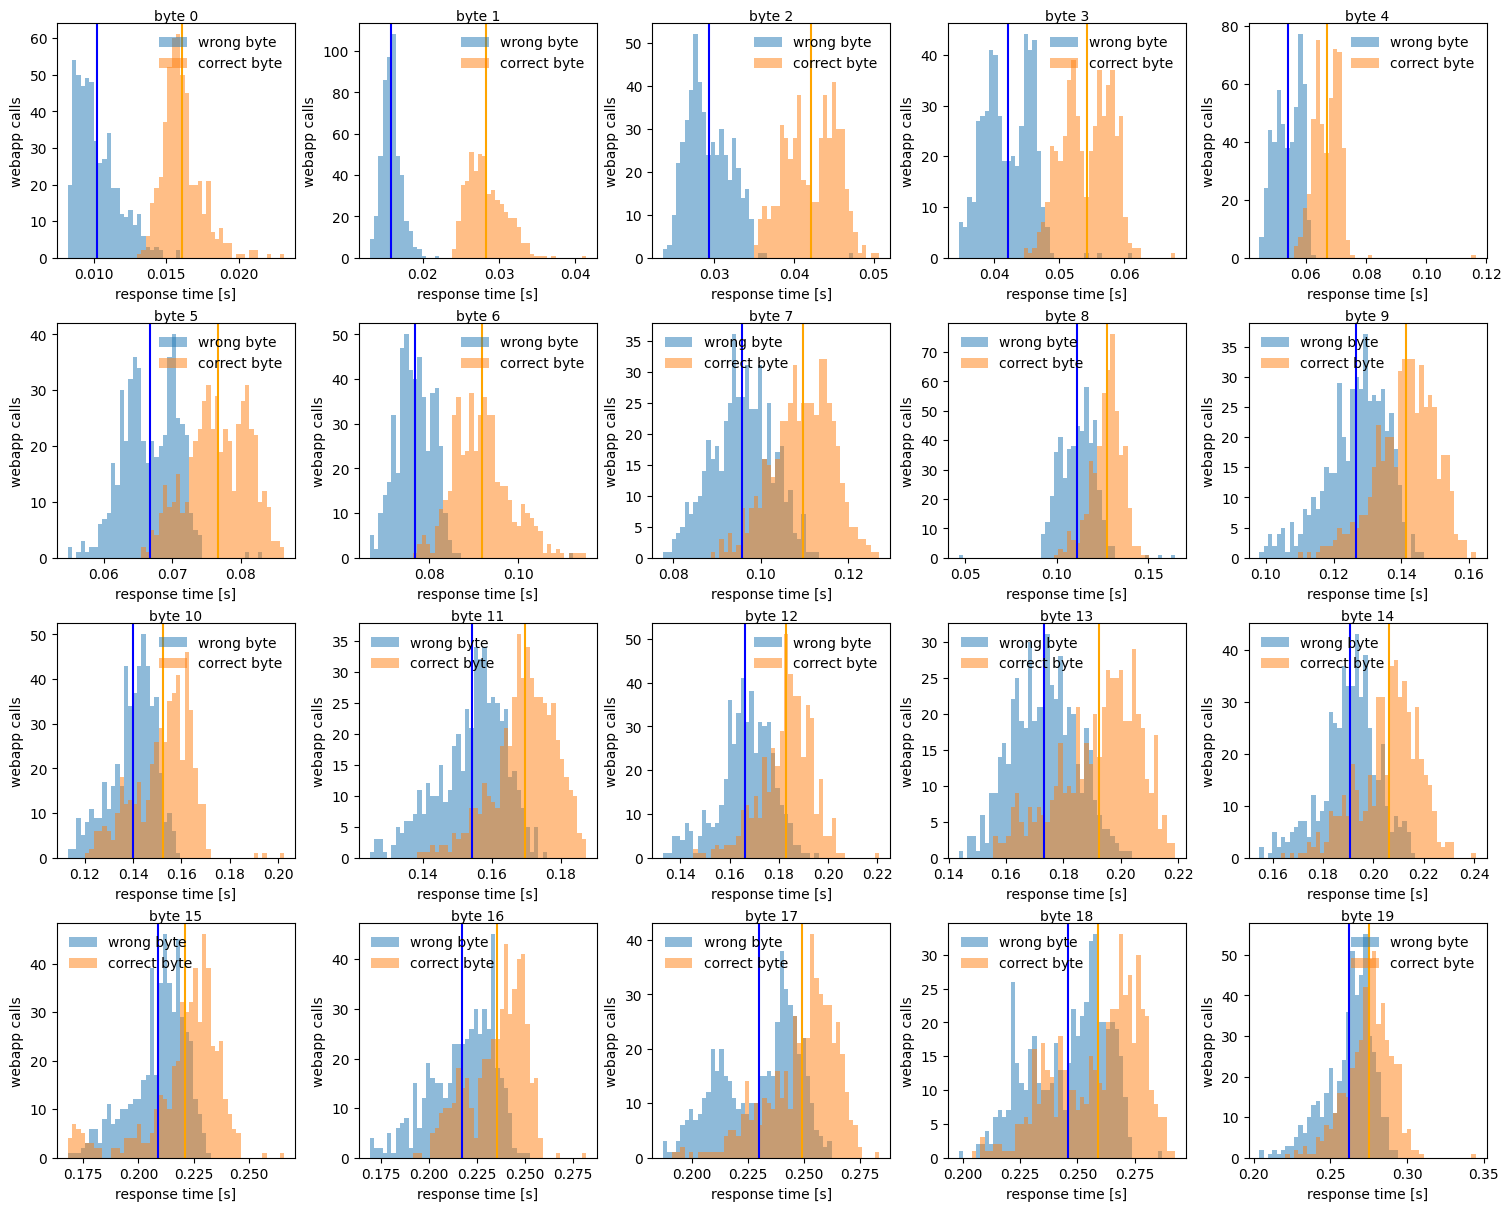

In [177]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,5,figsize=(15,12),dpi=100,constrained_layout=True)

for b in range(20):
    i = b%5
    j = b//5
    bins = np.histogram(np.stack((times[b][0],times[b][1])), bins=50)[1]
    axs[j][i].hist(times[b][0],bins,alpha=0.5, label="wrong byte")
    axs[j][i].hist(times[b][1],bins,alpha=0.5, label="correct byte")
    mean0 = np.array(times[b][0]).mean()
    mean1 = np.array(times[b][1]).mean()
    axs[j][i].axvline(x=mean0,color="blue")
    axs[j][i].axvline(x=mean1,color="orange")
    axs[j][i].set_xlabel("response time [s]")
    axs[j][i].set_ylabel("webapp calls")
    axs[j][i].set_title(f"byte {b}",fontsize=10,pad=0)
    axs[j][i].legend(frameon=False)